In [ ]:
# The goal is this code is to create a (inMotion, motionType, and motionDirectoin) columns
# for each player for each frame

Player: A.J. Brown, Motion Frames: []
Player: Dallas Goedert, Motion Frames: []
Player: DeVonta Smith, Motion Frames: []
Player: Miles Sanders, Motion Frames: []
Player: Quez Watkins, Motion Frames: [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161]
Player: A.J. Brown, No motion frames.
Player: Dallas Goedert, No motion frames.
Player: DeVonta Smith, No motion frames.
Player: Miles Sanders, No motion frames.
Player: Quez Watkins, Last Motion Frame = Last Frame in Data: True
Number of players with motion frames > 0: 1
Number of players whose motion ends at the last frame: 1
Motion type: single combined


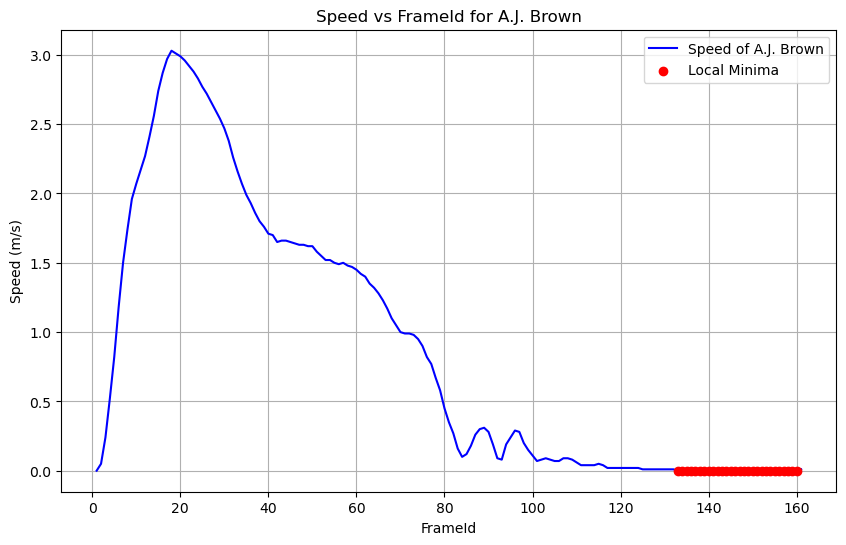

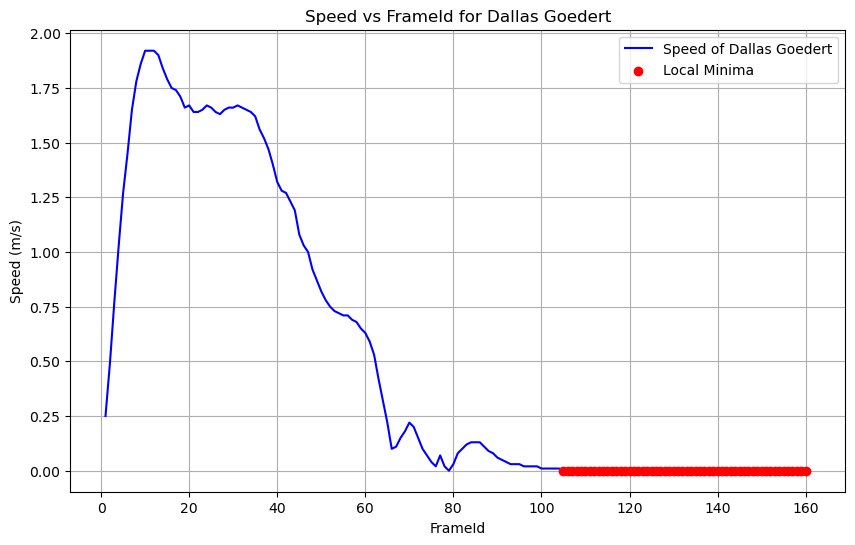

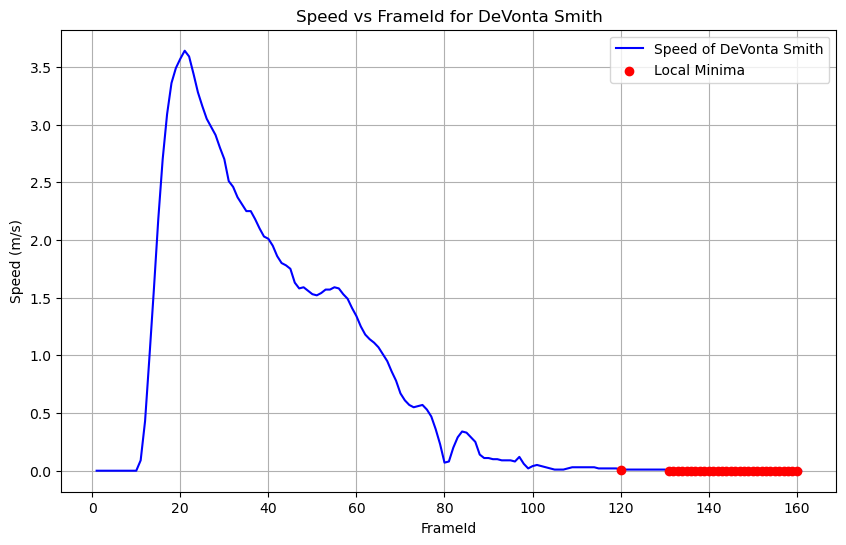

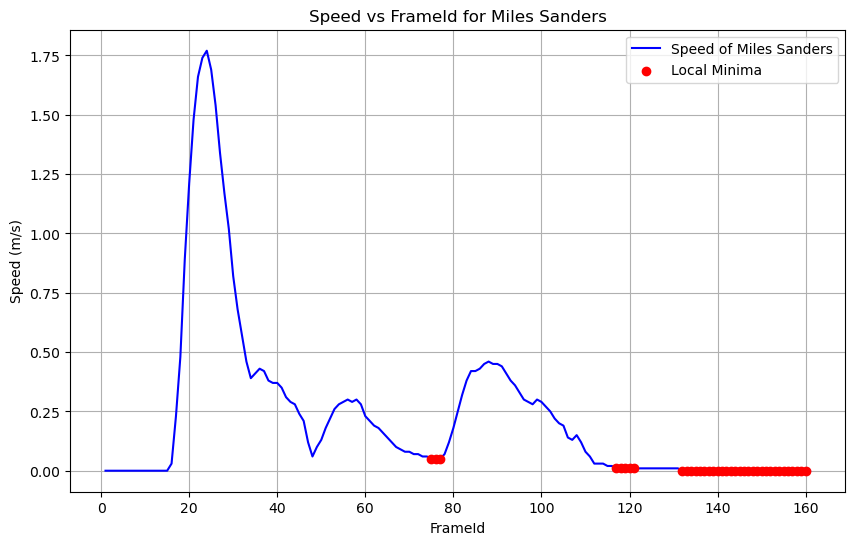

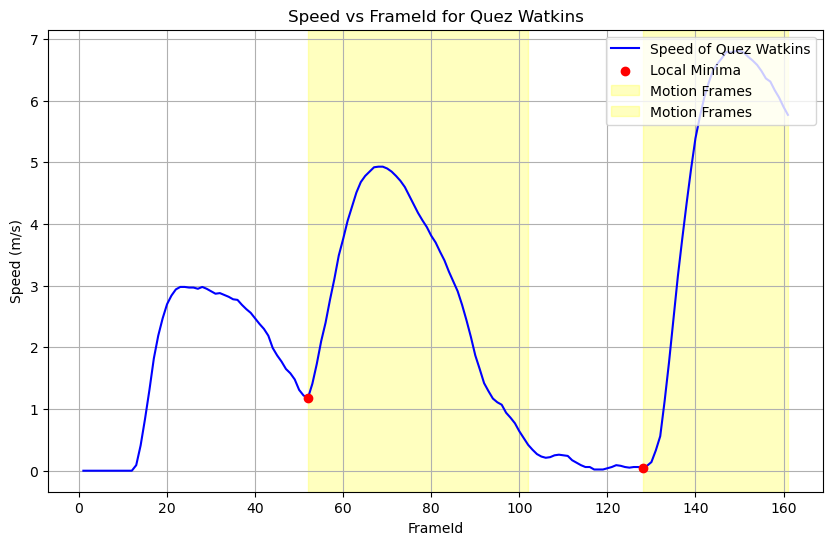

In [8]:
# Importing necessary libraries for data manipulation, visualization, and motion analysis
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from IPython.display import display

# Load the datasets (ensure correct paths and files)
games_df = pd.read_csv('../../data/games.csv')  # Games data
plays_df = pd.read_csv('../../data/plays.csv')  # Play information
players_df = pd.read_csv('../../data/players.csv')  # Player data
player_play_df = pd.read_csv('../../data/player_play.csv')  # Player-play relation data

# Specify the playId and gameId to display (specific plays and games to analyze)
# Example plays are commented out, selecting a Week 3 play for analysis
play_id_to_display = 713
game_id_to_display = 2022091104

# Determine the week of the game and load tracking data for that specific week
week = games_df.loc[games_df['gameId'] == game_id_to_display, 'week'].squeeze()
tracking_data = pd.read_csv(f'../../data/tracking_week_{week}.csv')  # Tracking data for the selected week

# Filter tracking data for specific play and game
tracking_play_data = tracking_data[(tracking_data['gameId'] == game_id_to_display) & (tracking_data['playId'] == play_id_to_display)]

# Filter for frames corresponding to the presnap phase (before snap and at snap)
presnap_tracking_data = tracking_play_data[
    tracking_play_data['frameType'].isin(['BEFORE_SNAP', 'SNAP'])
]

# Merge player position data into tracking data to add player roles (e.g., QB, WR)
presnap_tracking_data = presnap_tracking_data.merge(
    players_df[['displayName', 'position']],  # Select relevant columns (name and position)
    on='displayName',  # Merge on the displayName (player name)
    how='left'  # Left join to retain all rows from the tracking data
)

# Define offensive positions for filtering (WR, RB, TE, FB are considered offensive)
offensive_positions = ['WR', 'RB', 'TE', 'FB']
remaining_positions = ['QB', 'G', 'T', 'C']  # Remaining positions like QB and linemen

# Filter the tracking data for offensive players and non-offensive positions
offensive_tracking_data = presnap_tracking_data[presnap_tracking_data['position'].isin(offensive_positions)]
remaining_positions_data = presnap_tracking_data[presnap_tracking_data['position'].isin(remaining_positions)]

# Group the offensive tracking data by player to analyze their individual movements
offensive_groups = offensive_tracking_data.groupby('displayName')

# Function to detect motion direction based on changes in the Y-position of players
def detect_motion_direction(data, motion_frames):
    directions = ['no motion'] * len(data)  # Default direction is 'no motion'
    
    for i in range(1, len(data)):
        # Only consider frames where the player is in motion
        if data.iloc[i]['frameId'] in motion_frames:
            prev_y = data.iloc[i-1]['y']
            curr_y = data.iloc[i]['y']
            play_direction = data.iloc[i]['playDirection']

            # Determine direction based on changes in y-coordinate
            if play_direction == 'right':
                direction = 'left' if curr_y > prev_y else 'right' if curr_y < prev_y else 'no motion'
            elif play_direction == 'left':
                direction = 'right' if curr_y > prev_y else 'left' if curr_y < prev_y else 'no motion'

            directions[i] = direction

    data['motionDirection'] = directions  # Add a new column for motion direction
    return data

# Function to process motion frames (detects when a player is in motion based on speed changes)
def process_motion_frames(data, speed_minimum_for_motion=1.5, speed_threshold=0.5):
    maxima_frames = []  # Store local maxima (points of highest speed)
    minima_frames = []  # Store local minima (points where speed is low)
    motion_frames = []  # Store frames identified as in motion

    total_frames = len(data)  # Total number of frames in the data
    thirty_percent_frame = int(0.25 * total_frames)  # Threshold frame to start processing motion

    # Loop to detect local maxima and minima based on speed changes
    for i in range(1, total_frames - 1):
        current_speed = data.iloc[i]['s']
        prev_speed = data.iloc[i - 1]['s']
        next_speed = data.iloc[i + 1]['s']
        current_frame = data.iloc[i]['frameId']

        # Handle speed = 0 as a potential minima after 30% of the frames
        if current_frame > thirty_percent_frame and current_speed == 0:
            lookahead_data = data.iloc[i + 1:i + 11]
            if lookahead_data['s'].is_monotonic_increasing:
                minima_frames.append(current_frame)

        # Identify local maxima (high speed points)
        elif current_frame > thirty_percent_frame and current_speed >= prev_speed and current_speed >= next_speed and current_speed >= speed_minimum_for_motion:
            maxima_frames.append(current_frame)

        # Identify local minima with monotonic increase in speed after 30% of frames
        elif current_frame > thirty_percent_frame and current_speed <= prev_speed and current_speed <= next_speed and current_speed > 0:
            lookahead_data = data.iloc[i + 1:i + 11]
            if lookahead_data['s'].is_monotonic_increasing:
                minima_frames.append(current_frame)

    # Special case handling for the last frame if it meets criteria for maxima
    last_frame_idx = total_frames - 1
    last_frame_speed = data.iloc[last_frame_idx]['s']
    second_last_frame_speed = data.iloc[last_frame_idx - 1]['s']
    if last_frame_speed >= second_last_frame_speed and last_frame_speed >= speed_minimum_for_motion:
        maxima_frames.append(data.iloc[last_frame_idx]['frameId'])

    # Create motion segments based on maxima and minima frames
    motion_segments = []
    minima_idx = 0
    maxima_idx = 0

    # Identify motion segments from minima to maxima and check for where motion stops
    while minima_idx < len(minima_frames) and maxima_idx < len(maxima_frames):
        minima_frame = minima_frames[minima_idx]
        
        # Find the next maxima after this minima
        while maxima_idx < len(maxima_frames) and maxima_frames[maxima_idx] <= minima_frame:
            maxima_idx += 1
        
        if maxima_idx < len(maxima_frames):
            maxima_frame = maxima_frames[maxima_idx]
            segment_frames = data[(data['frameId'] >= minima_frame) & (data['frameId'] <= maxima_frame)]['frameId'].tolist()
            frames_after_maxima = data[data['frameId'] > maxima_frame]
            below_threshold_frames = frames_after_maxima[frames_after_maxima['s'] < speed_threshold]

            stop_frame = below_threshold_frames.iloc[0]['frameId'] if not below_threshold_frames.empty else data.iloc[-1]['frameId']
            segment_frames += data[(data['frameId'] > maxima_frame) & (data['frameId'] <= stop_frame)]['frameId'].tolist()
            motion_segments.append(segment_frames)
        
        minima_idx += 1

    # Flatten motion segments and remove duplicates
    for segment in motion_segments:
        motion_frames.extend(segment)
    motion_frames = sorted(set(motion_frames))  # Sort and remove duplicates

    # Add direction of motion based on position changes and frame IDs
    data = detect_motion_direction(data, motion_frames)

    return {
        "local_maxima_frames": maxima_frames,
        "local_minima_frames": minima_frames,
        "motion_frames": motion_frames,
        "data_with_motion_direction": data
    }

# Initialize a dictionary to store motion frames for each player
player_motion_results = {}

# Iterate over each offensive player and analyze their motion
for player_name, player_data in offensive_groups:
    player_data = player_data.sort_values(by='frameId')  # Sort data by frame ID for correct sequence
    results = process_motion_frames(player_data, speed_minimum_for_motion=1.5, speed_threshold=0.5)  # Process motion frames
    player_motion_results[player_name] = results['motion_frames']  # Store motion frames for the player

# Display the results (motion frames for each player)
for player, motion_frames in player_motion_results.items():
    print(f"Player: {player}, Motion Frames: {motion_frames}")

# Additional motion analysis and classification
motion_types = []  # List to store final motion classification
last_frame_in_data = offensive_tracking_data['frameId'].max()  # Get last frame ID from data
players_with_motion = 0  # Counter for players with motion
players_motion_ends_at_last_frame = 0  # Counter for players whose motion ends at the last frame

# Initialize dictionary to store if player's motion ends at last frame
player_last_frame_check = {}

# Iterate through players' motion frames and classify motion type
for player, motion_frames in player_motion_results.items():
    if motion_frames:
        players_with_motion += 1  # Increment count for players with motion
        motion_ends_at_last_frame = motion_frames[-1] == last_frame_in_data
        if motion_ends_at_last_frame:
            players_motion_ends_at_last_frame += 1
        
        player_last_frame_check[player] = motion_ends_at_last_frame  # Store last frame motion result
        print(f"Player: {player}, Last Motion Frame = Last Frame in Data: {motion_ends_at_last_frame}")
    else:
        player_last_frame_check[player] = False
        print(f"Player: {player}, No motion frames.")


# Classification logic
if players_with_motion == 0:
    motion_type = "no motion"
elif players_with_motion == 1:
    # Find the single player with motion
    single_player = next(player for player, frames in player_motion_results.items() if len(frames) > 0)
    motion_frames = player_motion_results[single_player]
    
    # Check for "single combined"
    gaps = [i for i in range(1, len(motion_frames)) if motion_frames[i] - motion_frames[i - 1] > 1]
    if gaps and motion_frames[-1] == last_frame_in_data:
        motion_type = "single combined"
    elif player_last_frame_check[single_player]:
        motion_type = "single motion"
    else:
        motion_type = "single shift"
else:
    # Check for "multi combined"
    players_motion_at_end = sum(1 for player, check in player_last_frame_check.items() if check)
    if players_motion_at_end == 1 and players_motion_ends_at_last_frame == 1:
        motion_type = "multi combined"
    elif players_motion_ends_at_last_frame == 0:
        motion_type = "multi shift"
    else:
        motion_type = "multi motion"

# Print results
print(f"Number of players with motion frames > 0: {players_with_motion}")
print(f"Number of players whose motion ends at the last frame: {players_motion_ends_at_last_frame}")
print(f"Motion type: {motion_type}")

# Initialize figure
fig = go.Figure()

# Iterate through each offensive player and plot speed vs frameId
for player, data in offensive_groups:
    # Sort by frameId
    data = data.sort_values(by='frameId')
    # Add trace for each player
    fig.add_trace(go.Scatter(
        x=data['frameId'],
        y=data['s'],  # Speed
        mode='lines',
        name=player,
        text=[f"Player: {player}, Speed: {speed:.2f}" for speed in data['s']],
        hoverinfo='text'
    ))

    
    
# Initialize an empty dictionary to store the combined data for each player
player_combined_data = {}

for player_name, motion_frames in player_motion_results.items():
    # Get the player's data from the original tracking data
    player_data = offensive_tracking_data[offensive_tracking_data['displayName'] == player_name]
    
    # Sort by frameId
    player_data = player_data.sort_values(by='frameId')
    
    # Create a new column 'inMotion' and assign it based on the motion frames
    player_data['inMotion'] = player_data['frameId'].isin(motion_frames)
    
    # Store the combined data in the dictionary
    player_combined_data[player_name] = player_data
    
    # Plot speed vs frameId
    plt.figure(figsize=(10, 6))
    plt.plot(player_data['frameId'], player_data['s'], label=f"Speed of {player_name}", color='blue')

        # Get the motion frames from the process_motion_frames function
    motion_data = process_motion_frames(player_data, speed_threshold=0.5)

    # Plot local minima on the speed vs frameId plot (with red dots)
    plt.scatter(motion_data['local_minima_frames'], 
                player_data[player_data['frameId'].isin(motion_data['local_minima_frames'])]['s'], 
                color='red', label='Local Minima', zorder=5)
    
    # Function to find contiguous ranges from motion frames
    def get_contiguous_segments(motion_frames):
        segments = []
        if not motion_frames:
            return segments  # Return empty list if no motion frames
        
        start = motion_frames[0]
        for i in range(1, len(motion_frames)):
            if motion_frames[i] != motion_frames[i-1] + 1:
                # If not consecutive, store the segment
                segments.append((start, motion_frames[i-1]))
                start = motion_frames[i]
        segments.append((start, motion_frames[-1]))  # Add the last segment
        return segments

    # Shade the motion frames in yellow, only if motion frames exist
    if motion_frames:
        motion_segments = get_contiguous_segments(motion_frames)
        
        # Shade each segment
        for start, end in motion_segments:
            plt.axvspan(start, end, color='yellow', alpha=0.25, label='Motion Frames')
    
    # Labeling the plot
    plt.title(f"Speed vs FrameId for {player_name}")
    plt.xlabel('FrameId')
    plt.ylabel('Speed (m/s)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(f"speed_vs_frameId_{player_name}.png")  # Save as PNG, you can change the format here

    plt.show()

In [9]:
#combined_df.to_csv("SEAfeatures_test.csv", index=False)

In [ ]:
import matplotlib.pyplot as plt
import imageio
import os

# Filter the data for Quez Watkins
quez_data = offensive_tracking_data[offensive_tracking_data['displayName'] == 'Quez Watkins']
quez_data = quez_data.sort_values(by='frameId')  # Ensure the data is sorted by frameId

# Assume motion_frames for Quez Watkins have been detected and stored in motion_frames
motion_frames = player_motion_results.get('Quez Watkins', [])  # Get the motion frames for Quez Watkins

# Create a directory to store the frames temporarily
output_dir = "quez_frames"
os.makedirs(output_dir, exist_ok=True)

# Function to add shading incrementally for each frame
def add_shading_for_motion(ax, motion_frames, up_to_frame):
    """
    Add yellow shading incrementally for the motion frames up to the current frame (up_to_frame).
    """
    # Filter out only the motion frames that are less than or equal to the current frame
    relevant_motion_frames = [frame for frame in motion_frames if frame <= up_to_frame]
    motion_segments = get_contiguous_segments(relevant_motion_frames)
    
    for start, end in motion_segments:
        ax.axvspan(start, end, color='yellow', alpha=0.3, label='Motion Frames')

# Generate individual frame plots
frame_files = []
for frame_id in quez_data['frameId'].unique():
    # Filter data for the current frame
    frame_data = quez_data[quez_data['frameId'] == frame_id]
    
    # Plot speed and position data
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(quez_data['frameId'], quez_data['s'], label='Speed (m/s)', color='blue')
    ax.scatter(frame_id, frame_data['s'], color='red', label=f'Frame {frame_id} (Current)', zorder=5)
    
    # Add yellow shading for motion frames up to the current frame
    add_shading_for_motion(ax, motion_frames, frame_id)
    
    # Annotate the current frame
    ax.set_title(f"Quez Watkins Motion: Frame {frame_id}")
    ax.set_xlabel('Frame ID')
    ax.set_ylabel('Speed (m/s)')
    ax.legend(loc='upper right')
    ax.grid(True)
    
    # Save the frame as an image
    frame_file = os.path.join(output_dir, f"frame_{frame_id}.png")
    plt.savefig(frame_file)
    frame_files.append(frame_file)
    plt.close()

# Combine the saved frames into a GIF
gif_path = "quez_watkins_motion.gif"
with imageio.get_writer(gif_path, mode='I', duration=0.1, loop=0) as writer:  # duration: time between frames
    for frame_file in frame_files:
        image = imageio.imread(frame_file)
        writer.append_data(image)

# Clean up the temporary frame files (optional)
for frame_file in frame_files:
    os.remove(frame_file)
os.rmdir(output_dir)

if os.path.exists(gif_path):
    print(f"GIF successfully saved at {gif_path}")
else:
    print("GIF not found. Check the path and permissions.")
